# Machine learning models

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
%matplotlib inline

In [2]:
nan_df = pd.read_csv("C:/Users/USER/Downloads/Holmusk_analysis/nan_df.csv")
final_df = pd.read_csv("C:/Users/USER/Downloads/Holmusk_analysis/final_df.csv")

## Test out models
We will test out 4 basic ML models:
- K-Nearest neighbours
- Linear regression
- Random forest

Can validate them using k-fold cross validation

In [29]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [11]:
X = final_df.drop(columns=["total_bill"]).to_numpy()
y = final_df["total_bill"].to_numpy()

Function to test models. Takes in:
- X: features
- y: labels
- n: number of splits for K Fold cross validation
- model: machine learning model to do the fitting and validation on

Only works on sklearn models due to the similar functions

In [15]:
def validate(X, y, n, model):
    kf = KFold(n_splits=n)
    k_error = 0
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Fit the model
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        # Calculate root mean squared error
        error = sqrt(mean_squared_error(y_test, pred))
        k_error += error
        
    return k_error / n

### K-nearest neighbours

Accuracy seems to be stuck at RMSE of 9530, at 53 neighbours

In [ ]:
# Optimise number of neighbours for knn

for i in range(2, 25):
    n_neighbors = i*4 + 1
    knn = KNeighborsRegressor(n_neighbors = n_neighbors)
    error = validate(X, y, 10, knn)
    print(f"Number of neighbours: {n_neighbors}, K-fold error: {error}")

### Linear regression

Performs much better, with RMSE of 5110

In [31]:
linreg = LinearRegression()
error = validate(X, y, 10, linreg)
print(f"Linear regression K-Fold error: {error}")

Linear regression K-Fold error: 5116.3464096912785


### Random forest

Best performing, with RMSE of 3100

In [32]:
rf = RandomForestRegressor()
error = validate(X, y, 10, rf)
print(f"Random forest K-Fold error: {error}")

Random forest K-Fold error: 3086.123619494778


## Basic feature engineering
Using mean decrease in impurity and feature permutation - 
https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

<Figure size 2880x1080 with 0 Axes>

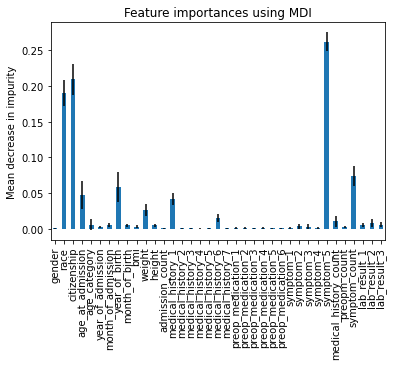

In [44]:
# Mean Decrease in Impurity
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

feature_names = list(final_df.columns)[:-1]
forest_importances = pd.Series(importances, index=feature_names)

plt.figure(figsize = (40,15))
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
plt.show()

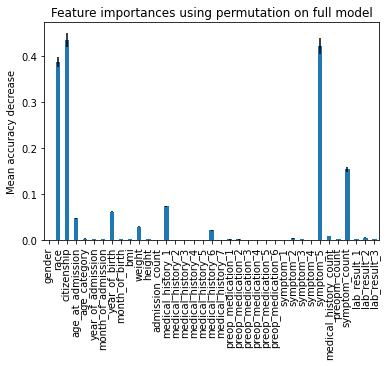

In [47]:
# Feature permutation
from sklearn.inspection import permutation_importance

result = permutation_importance(rf, X, y, n_repeats=10, n_jobs=2)

forest_importances = pd.Series(result.importances_mean, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
plt.show()

Both results show similar outcomes. The most important features are:
- race
- citizeship
- age_at_admission
- year_of_birth
- weight
- medical_history_1
- medical_history_6
- symptom_5
- symptom_count

Let's test the model again with just these features

In [50]:
features = ["race", "citizenship", "age_at_admission", "year_of_birth",
            "weight", "medical_history_1", "medical_history_6", "symptom_5",
            "symptom_count", "total_bill"]

new_df = final_df[features]

new_X = new_df.drop(columns=["total_bill"]).to_numpy()
new_y = new_df["total_bill"].to_numpy()

In [51]:
rf = RandomForestRegressor()
error = validate(new_X, new_y, 10, rf)
print(f"Random forest K-Fold error: {error}")

Random forest K-Fold error: 2637.584603887907


And we get a 10% improvement in RMSE! 